In [1]:
%run Transformer.ipynb
%run RNN.ipynb

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# Load the dataset, 15% of the trainning data used for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.15, stratify=y_train_valid)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train-769, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val-769, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test-769, dtype=torch.long)

print(X_train.shape)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)

torch.Size([1797, 22, 1000])


In [2]:
def randomly_crop(X, crop_len):
    # Randomly crop part of the sequence
    seq_len = X.shape[2]
    start_i = torch.randint(0, seq_len-crop_len+1, (1,))
    crop_idx = torch.arange(crop_len) + start_i
    croppedX = X[:, :, crop_idx]
    return croppedX

def model_train(num_epochs, model, optimizer, dataloader, X_val, y_val, X_test, y_test, seq_len):
    val_acc = []
    val_loss = []
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    crit = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
    for i in range(num_epochs):
        batch_loss = []
        batch_acc = []
        model.train()
        for X_train, y_train in dataloader:
            optimizer.zero_grad()
            
            # Crop training sequence and add noide
            crop_len = np.random.randint(seq_len-10, seq_len+11)
            X_train = X_train[:, :, :seq_len+10]
            X_train = X_train + torch.randn(X_train.shape)/2
            X_train = randomly_crop(X_train, crop_len)
            y_predict = model(X_train)
            loss = crit(y_predict, y_train)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            # Log training history for this epoch
            batch_loss.append(loss.item())
            y_predict = torch.argmax(model(X_train), dim=1)
            batch_acc.append((y_predict==y_train).sum().item()/y_train.shape[0])
        
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        # Evaluation on the eval set and log info
        model.eval()
        scores = model(X_val[:, :, :seq_len])
        y_predict = torch.argmax(scores, dim=1)
        validation_accuracy = ((y_predict==y_val).sum().item()/y_val.shape[0])
        val_acc.append(validation_accuracy)
        loss = crit(scores, y_val)
        val_loss.append(loss.item())
        
        
        # Evaluation on the test set and log info
        scores = model(X_test[:, :, :seq_len])
        y_predict = torch.argmax(scores, dim=1)
        test_accuracy = ((y_predict==y_test).sum().item()/y_test.shape[0])
        test_acc.append(test_accuracy)
        loss = crit(scores, y_test)
        test_loss.append(loss.item())
        
        # Save the model with the best performance
        """
        if validation_accuracy > max(val_acc):
            torch.save(model, "best_val.pth")
        if loss < min(val_loss):
            torch.save(model, "best_loss.pth")
        """
        
        if i%30 == 0:
            print("Iter", i)
            print("Training Loss: ", np.mean(train_loss[-30:]))
            print("Training accuracy: ", np.mean(train_acc[-30:]))
            print("Validation Loss: ", np.mean(val_loss[-30:]))
            print("Validation Accuracy: ", np.mean(val_acc[-30:]))
            print("Test Loss: ", np.mean(test_loss[-30:]))
            print("Test Accuracy: ", np.mean(test_acc[-30:]))
            print()
    
    return train_loss, train_acc, val_loss, val_acc, test_loss, test_acc

def plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc):
    # Plot the training history
    print(max(test_acc))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'pink', label='Train')
    plt.plot(val_loss, 'mediumspringgreen', label='Validation')
    plt.plot(test_loss, 'skyblue', label='Test')
    plt.title('Loss Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, 'pink', label='Train')
    plt.plot(val_acc, 'mediumspringgreen', label='Validation')
    plt.plot(test_acc, 'skyblue', label='Test')
    plt.title('Accuracy Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return

In [3]:
t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
transformer = Transformer(t_config)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(1000, 
                                                                            transformer, 
                                                                            transformer_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            600)

Iter 0
Training Loss:  1.4870244545095108
Training accuracy:  0.268235294117647
Validation Loss:  1.3893918991088867
Validation Accuracy:  0.29559748427672955
Test Loss:  1.399330973625183
Test Accuracy:  0.24830699774266365

Iter 30
Training Loss:  1.3292589019326604
Training accuracy:  0.3731176470588235
Validation Loss:  1.3247553904851277
Validation Accuracy:  0.3646750524109015
Test Loss:  1.3124664743741354
Test Accuracy:  0.3779533483822422

Iter 60
Training Loss:  1.0620747175871155
Training accuracy:  0.6095098039215686
Validation Loss:  1.108077472448349
Validation Accuracy:  0.580083857442348
Test Loss:  1.1103989283243816
Test Accuracy:  0.5560571858540256

Iter 90
Training Loss:  0.9077863792578379
Training accuracy:  0.7065686274509805
Validation Loss:  1.0032277226448059
Validation Accuracy:  0.6656184486373167
Test Loss:  1.0210695326328278
Test Accuracy:  0.633559066967645

Iter 120
Training Loss:  0.8457602488059623
Training accuracy:  0.7456862745098041
Validation Lo

0.7765237020316027


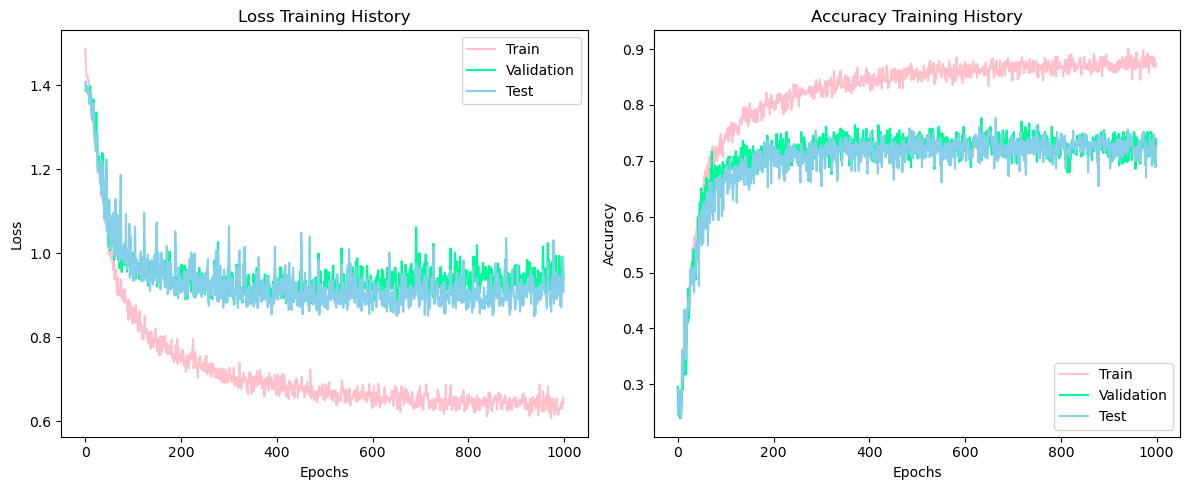

In [4]:
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)

In [5]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':True,
            'use_attention':True}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(300, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            600)

Iter 0
Training Loss:  1.3887325174668257
Training accuracy:  0.25411764705882356
Validation Loss:  1.3859440088272095
Validation Accuracy:  0.29874213836477986
Test Loss:  1.3857944011688232
Test Accuracy:  0.29345372460496616

Iter 30
Training Loss:  1.1114205715703032
Training accuracy:  0.5628627450980392
Validation Loss:  1.2426336526870727
Validation Accuracy:  0.4841719077568134
Test Loss:  1.2390212337176005
Test Accuracy:  0.4529721595184349

Iter 60
Training Loss:  0.7826197004785725
Training accuracy:  0.7903333333333333
Validation Loss:  1.2236754814783732
Validation Accuracy:  0.5697064989517819
Test Loss:  1.2229259371757508
Test Accuracy:  0.5341610233258087

Iter 90
Training Loss:  0.6227772851785024
Training accuracy:  0.8947843137254902
Validation Loss:  1.2422604839007059
Validation Accuracy:  0.5875262054507339
Test Loss:  1.2446376482645671
Test Accuracy:  0.5656132430398796

Iter 120
Training Loss:  0.5389924685744679
Training accuracy:  0.9462941176470587
Validat

0.6320541760722348


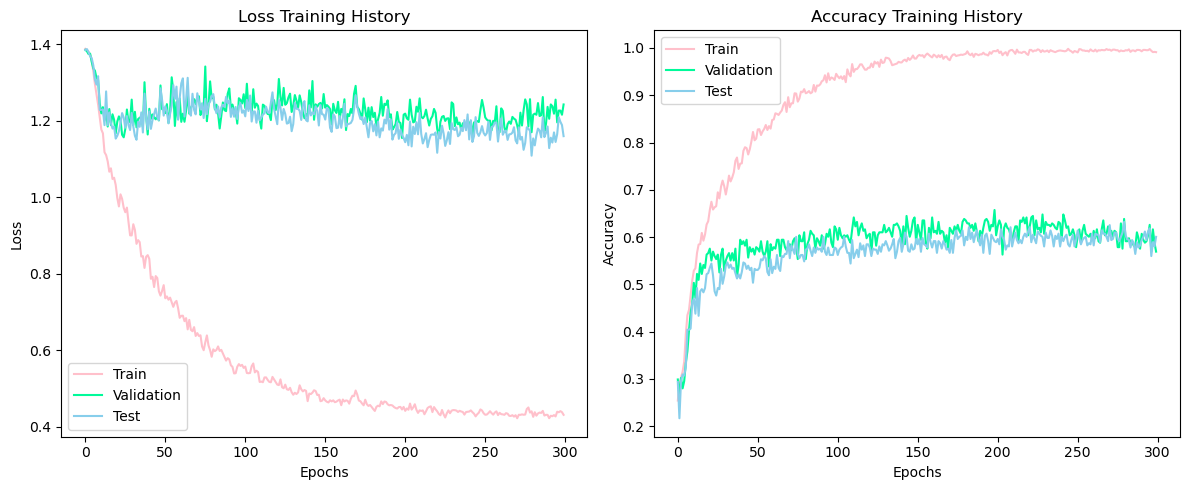

In [6]:
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)

In [7]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':False,
            'use_attention':True}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(300, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            600)

Iter 0
Training Loss:  1.3873702498043285
Training accuracy:  0.26470588235294124
Validation Loss:  1.3845162391662598
Validation Accuracy:  0.2641509433962264
Test Loss:  1.387748122215271
Test Accuracy:  0.2528216704288939

Iter 30
Training Loss:  1.3385426151986217
Training accuracy:  0.37029411764705883
Validation Loss:  1.3894320964813232
Validation Accuracy:  0.30178197064989515
Test Loss:  1.3747792442639668
Test Accuracy:  0.32249811888638075

Iter 60
Training Loss:  1.1917173991016312
Training accuracy:  0.5072352941176471
Validation Loss:  1.3439213713010152
Validation Accuracy:  0.4025157232704403
Test Loss:  1.3142750898996989
Test Accuracy:  0.4097817908201656

Iter 90
Training Loss:  1.043700946195453
Training accuracy:  0.6186078431372548
Validation Loss:  1.341687814394633
Validation Accuracy:  0.44842767295597485
Test Loss:  1.2874193469683328
Test Accuracy:  0.45086531226486065

Iter 120
Training Loss:  0.9492689421363903
Training accuracy:  0.6867254901960783
Validat

0.5304740406320542


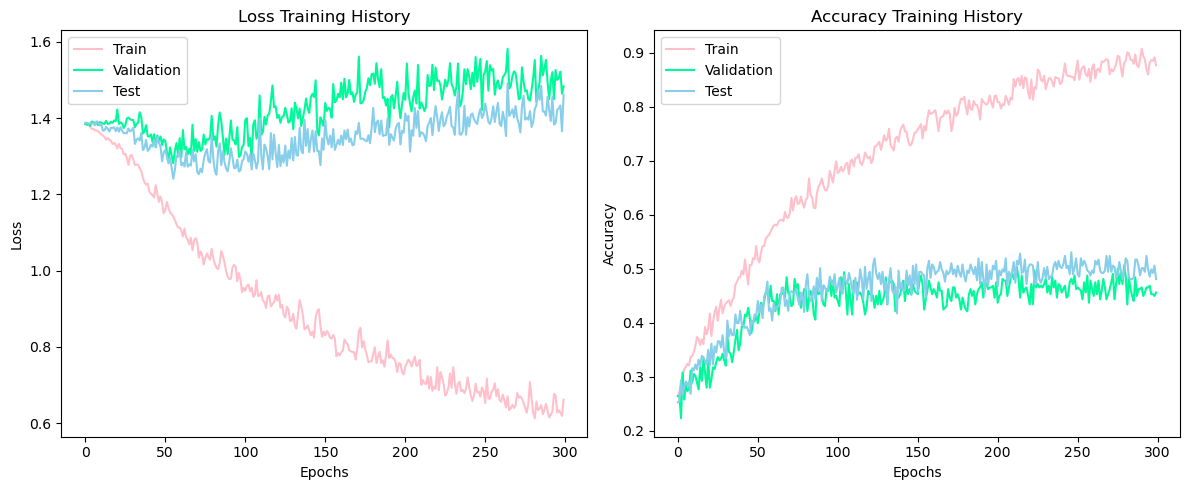

In [8]:
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)